# Ансамблі моделей

Випадковий ліс – це ансамбль дерев прийняття рішень, які навчаються зазвичай методом беггінга або іноді вставки і, як правило, з параметром max_samples рівним розміру навчальної вибірки.

Випадковий ліс вводить додаткову випадковість у дерева за рахунок того, що при розщепленні вузла він шукає найкращу ознаку у випадковому піднаборі ознак, замість пошуку найкращої ознаки серед усіх ознак. В результаті виходять більш відмінні, несхожі одне на одне дерева. Можна зробити дерева ще більш випадковими за рахунок застосування випадкових порогів для кожної ознаки замість пошуку найкращих можливих порогів, як це робиться у звичайних деревах прийняття рішень.

Ліс з такими надзвичайно випадковими деревами називається ансамблем особливо випадкових дерев (extremely randomized trees ensemble або просто extra-trees).

In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
X1, y1_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
rng = np.random.RandomState(13)
X1_stretched = np.dot(X1, rng.randn(2, 2))

np.random.seed(0)
X2 = np.random.randn(300, 2)
Y2 = np.logical_xor(X2[:, 0] > 0, X2[:, 1] > 0)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Представити початкові дані графічно

In [2]:
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
scaler = StandardScaler().fit(X1)
X1 = scaler.transform(X1)
scaler = StandardScaler().fit(X2)
X2 = scaler.transform(X2)

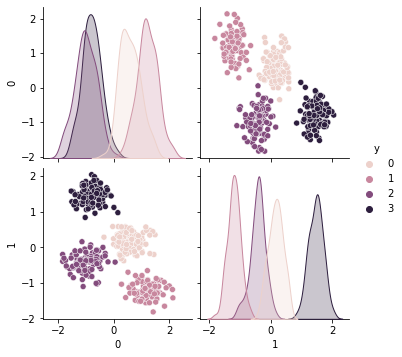

In [4]:
df1 = pd.DataFrame(X1) 
df1['y'] = y1_true.astype("int") 
sns.pairplot(df1, hue='y')

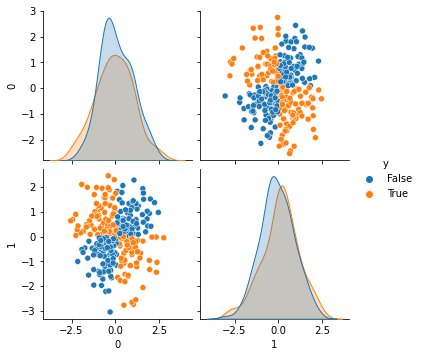

In [5]:
df2 = pd.DataFrame(X2)
df2['y'] = Y2.astype("bool")
data = df2
sns.pairplot(df2, hue='y')

# Побудувати моделi нейронних мереж, використовуючи класи MLPClassifier для класифiкацiї

Зробити висновки про якiсть роботи моделей нейронних мереж на дослiджених даних. В задачах класифiкацiї для кожної навчальної вибiрки вибрати найкращу модель за критерiями якостi:

• матриця неточностей (confusion matrix),

• точнiсть (precision),

• повнота (recall),

• мiра F1 (F1 score),

• ROC-крива, показник AUC.

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
precision_recall_curve)
from sklearn.preprocessing import label_binarize

In [7]:
num_of_classes = 3
y1_discrete = pd.cut(y1_true, bins=num_of_classes, labels=np.arange(num_of_classes), right=False).astype('int')
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1_discrete, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

In [8]:
def roc_plot(true, probs, num_classes):
    if num_classes != 0:
        y_test = label_binarize(true, classes=[*range(num_classes)])
        fpr = dict()
        tpr = dict()

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
            plt.plot(fpr[i], tpr[i], label='class {}'.format(i))
            plt.legend(loc='best')
    
    else:
        fpr, tpr, _ = roc_curve(true, probs[:, 1])
        plt.plot(fpr, tpr)

    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve')
    plt.show()
            
    
def analyze_model(model, x_test, y_test, x_train, y_train, num_classes=0):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    probs = model.predict_proba(x_test)
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=0, square=True) 
    plt.show()
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')
    f1 = f1_score(y_test, y_predict, average='macro')
    print("Precision score: ", precision)
    print("Recall score: ", recall)
    print("F1 score: ", f1)
    roc_plot(y_test, probs, num_classes)
    print("\nLoss curve:")
    loss_values = model.loss_curve_
    plt.plot(loss_values)
    plt.show()
    print("Test score: ", model.score(x_test, y_test))
    print("Train score: ", model.score(x_train, y_train))
    return f1, precision, recall

## make_blobs

Confusion matrix:


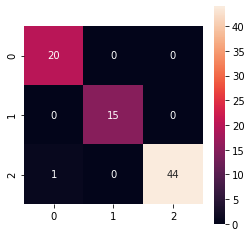

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127


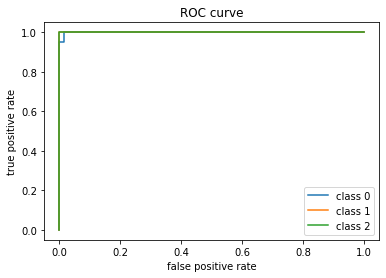


Loss curve:


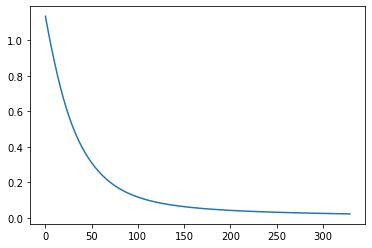

Test score:  0.9875
Train score:  0.996875


(0.988124600347127, 0.9841269841269842, 0.9925925925925926)

In [9]:
classifier = MLPClassifier(max_iter=500)
analyze_model(classifier, X1_test, y1_test, X1_train, y1_train, num_classes=num_of_classes)

### Параметр регуляризацiї alpha та early_stopping


MLPClassifier alpha=10, early_stopping = False
Confusion matrix:


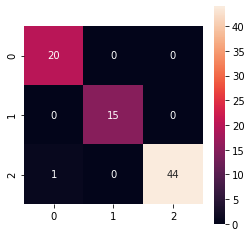

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127


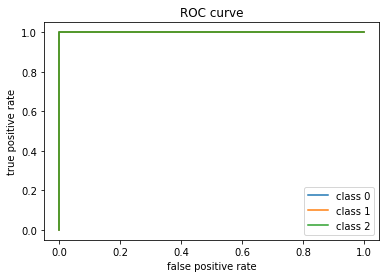


Loss curve:


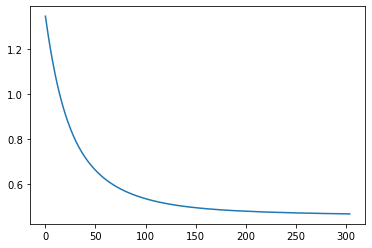

Test score:  0.9875
Train score:  0.9875

MLPClassifier alpha=1, early_stopping = False
Confusion matrix:


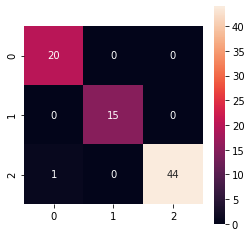

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127


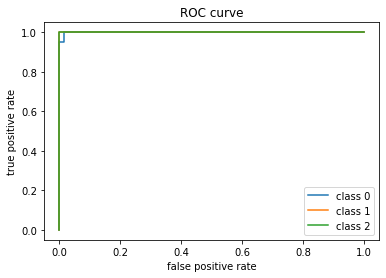


Loss curve:


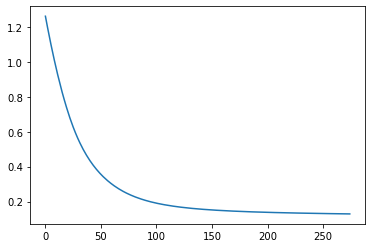

Test score:  0.9875
Train score:  0.99375

MLPClassifier alpha=0.1, early_stopping = False
Confusion matrix:


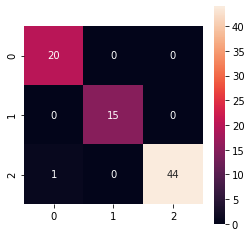

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127


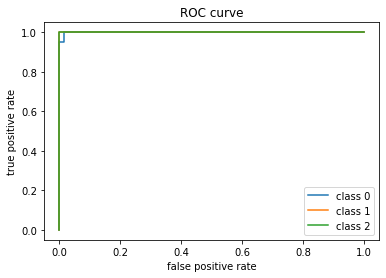


Loss curve:


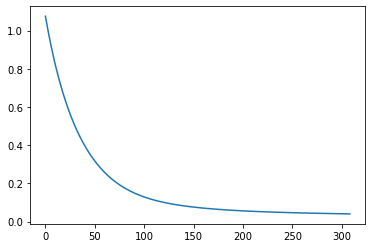

Test score:  0.9875
Train score:  0.99375

MLPClassifier alpha=0.01, early_stopping = False
Confusion matrix:


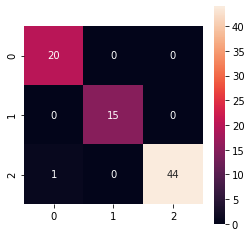

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127


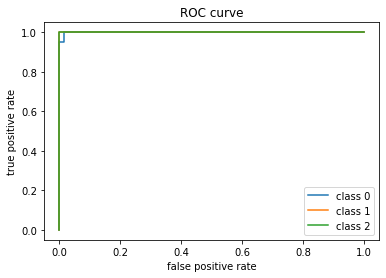


Loss curve:


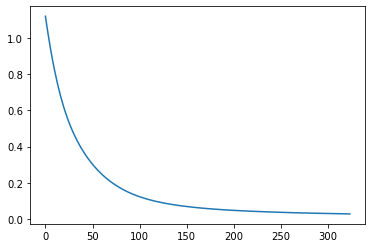

Test score:  0.9875
Train score:  0.99375

MLPClassifier alpha=0.001, early_stopping = False
Confusion matrix:


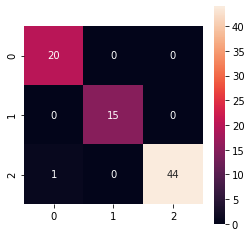

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127


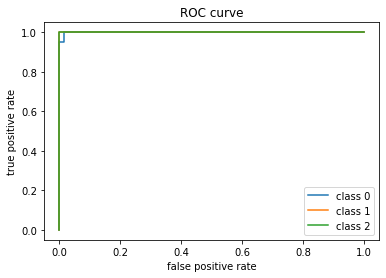


Loss curve:


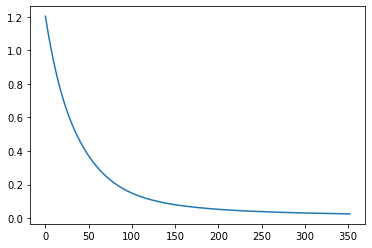

Test score:  0.9875
Train score:  0.99375

MLPClassifier alpha=10, early_stopping = True
Confusion matrix:


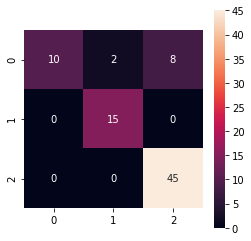

Precision score:  0.9104698483166852
Recall score:  0.8333333333333334
F1 score:  0.8408446712018139


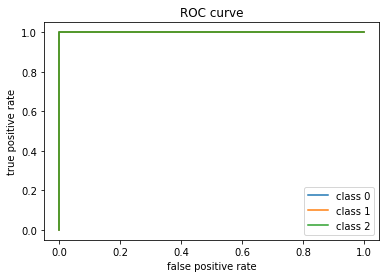


Loss curve:


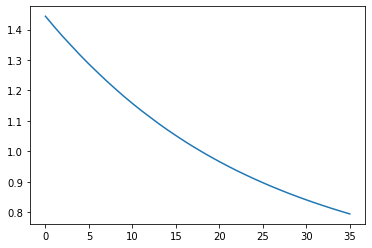

Test score:  0.875
Train score:  0.91875

MLPClassifier alpha=1, early_stopping = True
Confusion matrix:


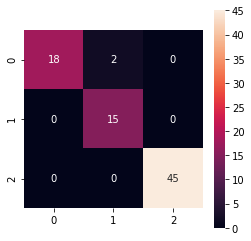

Precision score:  0.9607843137254902
Recall score:  0.9666666666666667
F1 score:  0.961622807017544


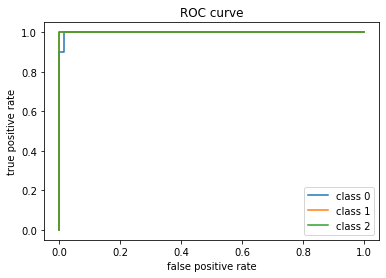


Loss curve:


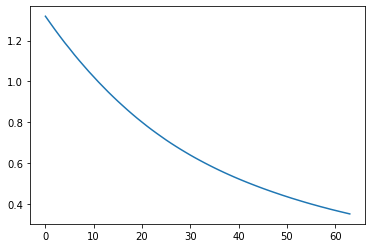

Test score:  0.975
Train score:  0.95625

MLPClassifier alpha=0.1, early_stopping = True
Confusion matrix:


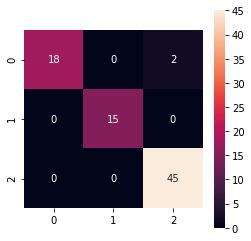

Precision score:  0.9858156028368795
Recall score:  0.9666666666666667
F1 score:  0.975209763539283


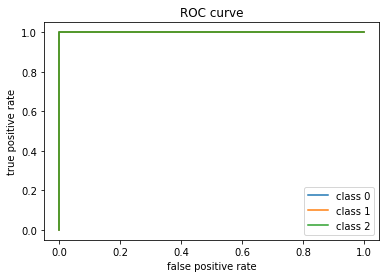


Loss curve:


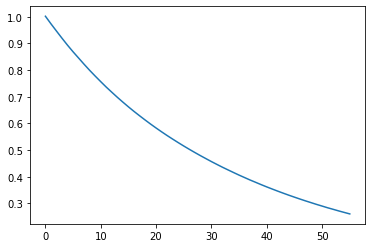

Test score:  0.975
Train score:  0.965625

MLPClassifier alpha=0.01, early_stopping = True
Confusion matrix:


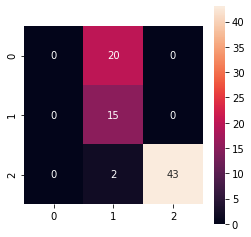

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score:  0.4684684684684685
Recall score:  0.6518518518518519
F1 score:  0.5180652680652681


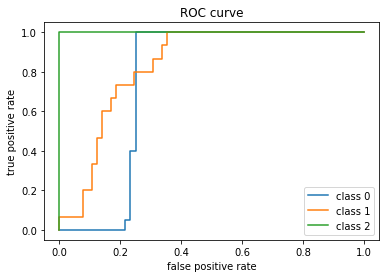


Loss curve:


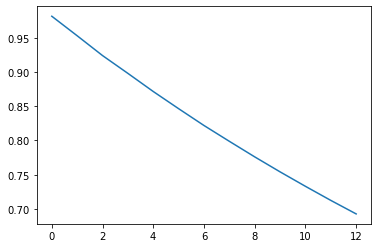

Test score:  0.725
Train score:  0.721875

MLPClassifier alpha=0.001, early_stopping = True
Confusion matrix:


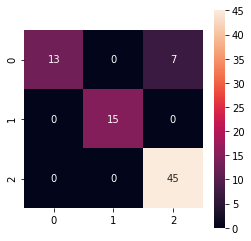

Precision score:  0.9551282051282052
Recall score:  0.8833333333333333
F1 score:  0.9052379464750601


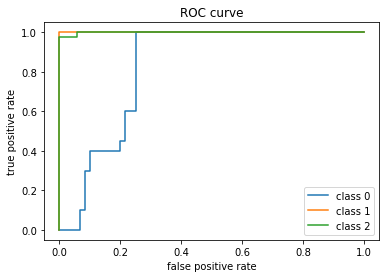


Loss curve:


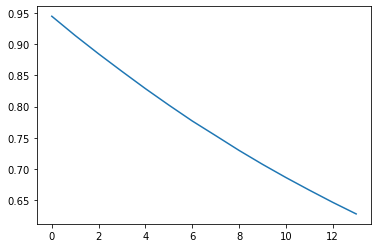

Test score:  0.9125
Train score:  0.95


In [10]:
alpha = [10 ** (-i) for i in range(-1, 4)]
early_stopping = [False, True]
result = {'alpha' : [], 'early_stopping' : [], 'f1' : [], 'precision' : [], 'recall' : []}
for e in early_stopping:
    for a in alpha:
        print(f"\nMLPClassifier alpha={a}, early_stopping = {e}")
        classifier = MLPClassifier(alpha=a, max_iter=500, early_stopping = e)
        f1, precision, recall = analyze_model(classifier, X1_test, 
                                              y1_test, X1_train, y1_train, num_classes=num_of_classes)
        result['alpha'].append(a)
        result['early_stopping'].append(e)
        result['f1'].append(f1)
        result['precision'].append(precision)
        result['recall'].append(recall)

In [11]:
results_df = pd.DataFrame(result)
results_df

,alpha,early_stopping,f1,precision,recall
0,10.000,False,0.988125,0.984127,0.992593
1,1.000,False,0.988125,0.984127,0.992593
2,0.100,False,0.988125,0.984127,0.992593
3,0.010,False,0.988125,0.984127,0.992593
4,0.001,False,0.988125,0.984127,0.992593
5,10.000,True,0.840845,0.910470,0.833333
6,1.000,True,0.961623,0.960784,0.966667
7,0.100,True,0.975210,0.985816,0.966667
8,0.010,True,0.518065,0.468468,0.651852
9,0.001,True,0.905238,0.955128,0.883333


In [12]:
results_df.sort_values(by='f1', ascending=False)

,alpha,early_stopping,f1,precision,recall
0,10.000,False,0.988125,0.984127,0.992593
1,1.000,False,0.988125,0.984127,0.992593
2,0.100,False,0.988125,0.984127,0.992593
3,0.010,False,0.988125,0.984127,0.992593
4,0.001,False,0.988125,0.984127,0.992593
7,0.100,True,0.975210,0.985816,0.966667
6,1.000,True,0.961623,0.960784,0.966667
9,0.001,True,0.905238,0.955128,0.883333
5,10.000,True,0.840845,0.910470,0.833333
8,0.010,True,0.518065,0.468468,0.651852


Як ми бачимо з графіків та метрик, найкращим параметром виявилось alpha=10, early_stopping=False. Окрім цього слід зауважити, що цей набір даних показує однаково гарні результати майже на усіх наборах параметрів (через гарну роздільність даних).

## logical_xor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix:


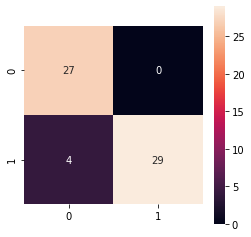

Precision score:  0.935483870967742
Recall score:  0.9393939393939394
F1 score:  0.9332591768631813


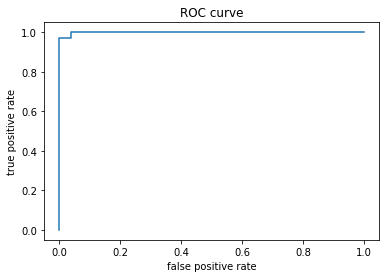


Loss curve:


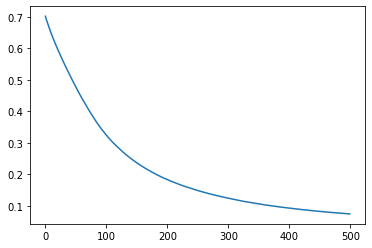

Test score:  0.9333333333333333
Train score:  0.9958333333333333


(0.9332591768631813, 0.935483870967742, 0.9393939393939394)

In [13]:
classifier = MLPClassifier(max_iter=500)
analyze_model(classifier, X2_test, y2_test, X2_train, y2_train, num_classes=0)

### Параметр регуляризацiї alpha та early_stopping


MLPClassifier alpha=10, early_stopping = False
Confusion matrix:


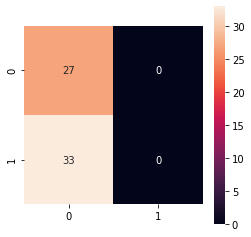

Precision score:  0.225
Recall score:  0.5
F1 score:  0.3103448275862069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


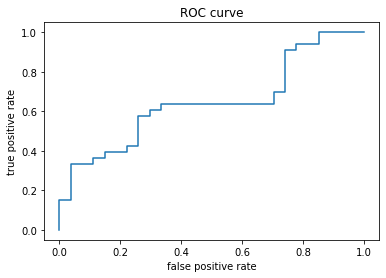


Loss curve:


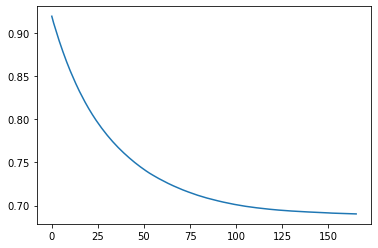

Test score:  0.45
Train score:  0.5875

MLPClassifier alpha=1, early_stopping = False
Confusion matrix:


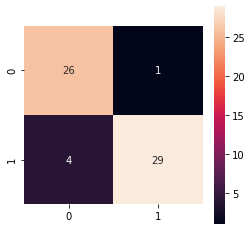

Precision score:  0.9166666666666667
Recall score:  0.9208754208754208
F1 score:  0.9164578111946533


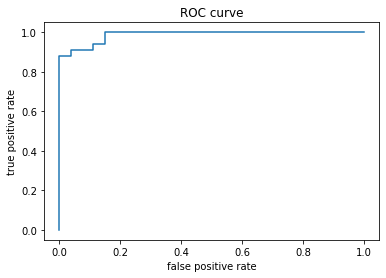


Loss curve:


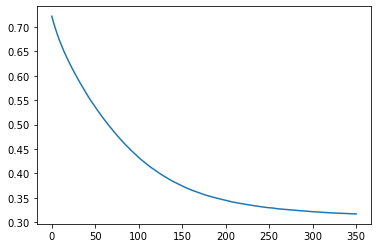

Test score:  0.9166666666666666
Train score:  0.975

MLPClassifier alpha=0.1, early_stopping = False
Confusion matrix:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


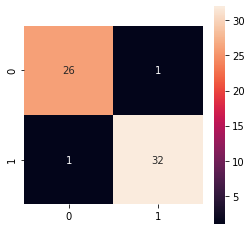

Precision score:  0.9663299663299663
Recall score:  0.9663299663299663
F1 score:  0.9663299663299663


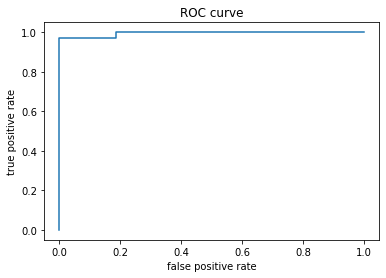


Loss curve:


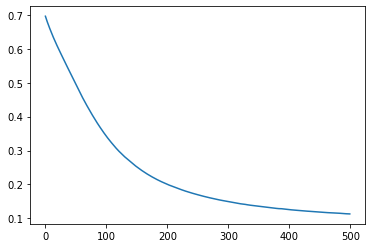

Test score:  0.9666666666666667
Train score:  0.9916666666666667

MLPClassifier alpha=0.01, early_stopping = False


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix:


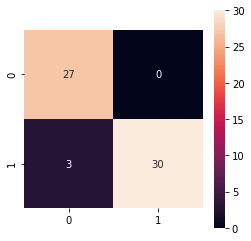

Precision score:  0.95
Recall score:  0.9545454545454546
F1 score:  0.949874686716792


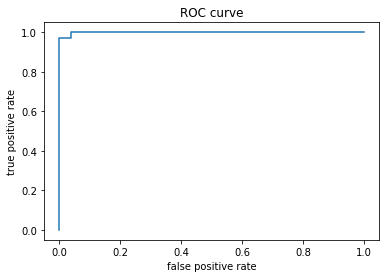


Loss curve:


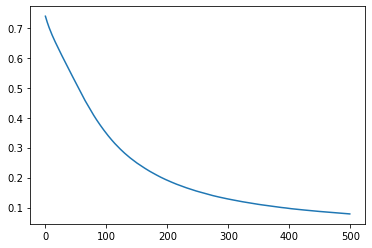

Test score:  0.95
Train score:  0.9916666666666667

MLPClassifier alpha=0.001, early_stopping = False


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix:


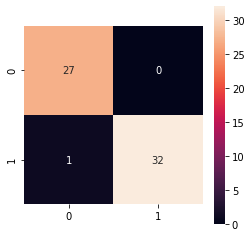

Precision score:  0.9821428571428572
Recall score:  0.9848484848484849
F1 score:  0.9832167832167833


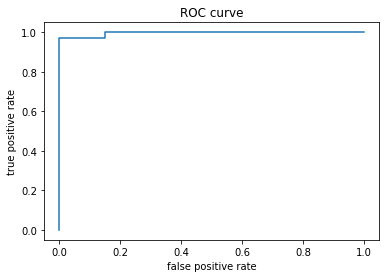


Loss curve:


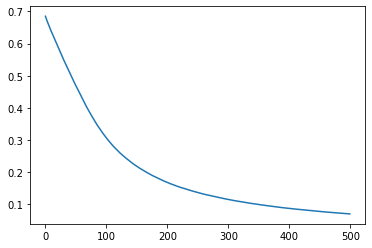

Test score:  0.9833333333333333
Train score:  0.9958333333333333

MLPClassifier alpha=10, early_stopping = True
Confusion matrix:


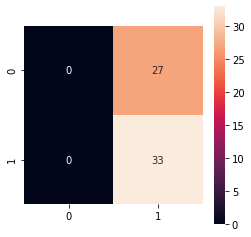

Precision score:  0.275
Recall score:  0.5
F1 score:  0.3548387096774194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


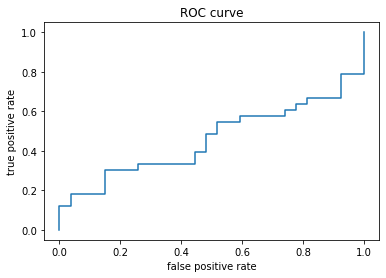


Loss curve:


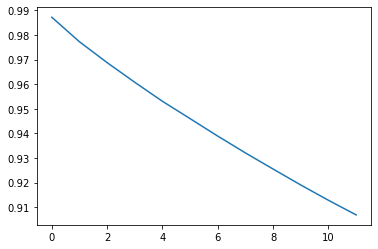

Test score:  0.55
Train score:  0.45416666666666666

MLPClassifier alpha=1, early_stopping = True
Confusion matrix:


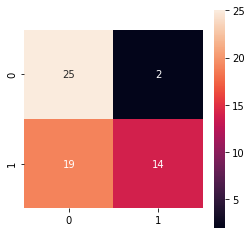

Precision score:  0.7215909090909092
Recall score:  0.6750841750841751
F1 score:  0.6378269617706238


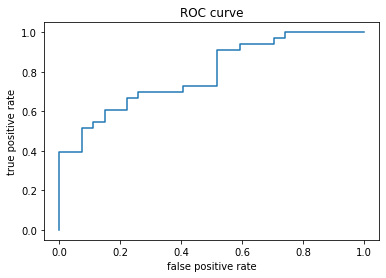


Loss curve:


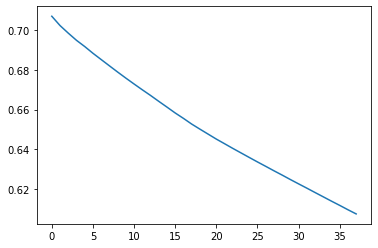

Test score:  0.65
Train score:  0.8291666666666667

MLPClassifier alpha=0.1, early_stopping = True
Confusion matrix:


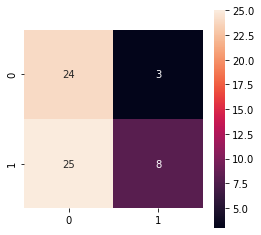

Precision score:  0.608534322820037
Recall score:  0.5656565656565656
F1 score:  0.49760765550239233


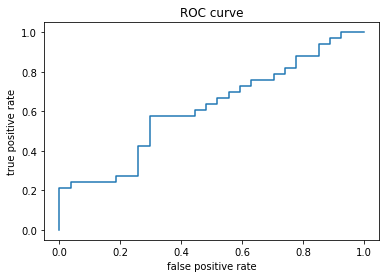


Loss curve:


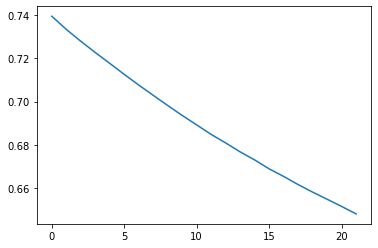

Test score:  0.5333333333333333
Train score:  0.5958333333333333

MLPClassifier alpha=0.01, early_stopping = True
Confusion matrix:


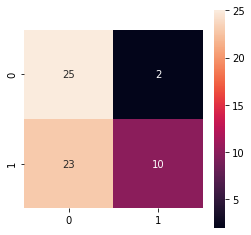

Precision score:  0.6770833333333334
Recall score:  0.6144781144781145
F1 score:  0.5555555555555556


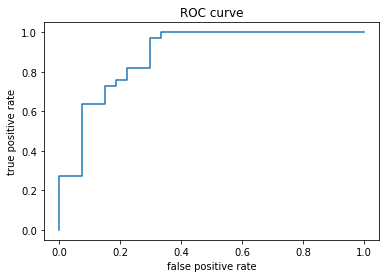


Loss curve:


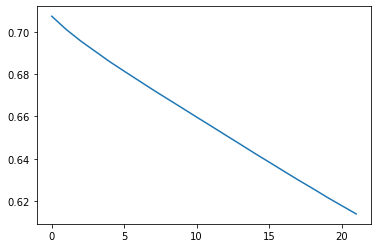

Test score:  0.5833333333333334
Train score:  0.7541666666666667

MLPClassifier alpha=0.001, early_stopping = True
Confusion matrix:


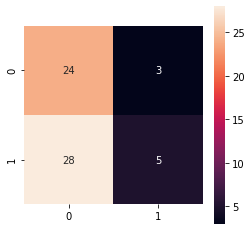

Precision score:  0.5432692307692308
Recall score:  0.5202020202020202
F1 score:  0.42574868786662545


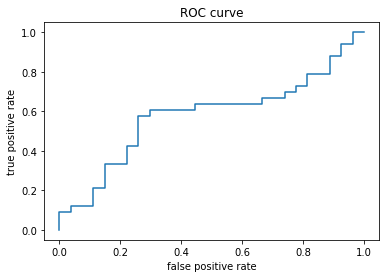


Loss curve:


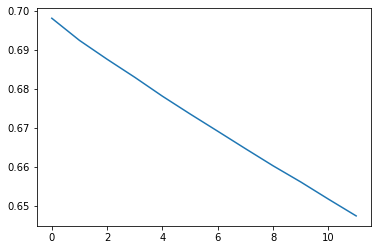

Test score:  0.48333333333333334
Train score:  0.5625


In [14]:
result = {'alpha' : [], 'early_stopping' : [], 'f1' : [], 'precision' : [], 'recall' : []}
for e in early_stopping:
    for a in alpha:
        print(f"\nMLPClassifier alpha={a}, early_stopping = {e}")
        classifier = MLPClassifier(alpha=a, max_iter=500, early_stopping = e)
        f1, precision, recall = analyze_model(classifier, X2_test, 
                                              y2_test, X2_train, y2_train, num_classes=0)
        result['alpha'].append(a)
        result['early_stopping'].append(e)
        result['f1'].append(f1)
        result['precision'].append(precision)
        result['recall'].append(recall)

In [15]:
results_df = pd.DataFrame(result)
results_df

,alpha,early_stopping,f1,precision,recall
0,10.000,False,0.310345,0.225000,0.500000
1,1.000,False,0.916458,0.916667,0.920875
2,0.100,False,0.966330,0.966330,0.966330
3,0.010,False,0.949875,0.950000,0.954545
4,0.001,False,0.983217,0.982143,0.984848
5,10.000,True,0.354839,0.275000,0.500000
6,1.000,True,0.637827,0.721591,0.675084
7,0.100,True,0.497608,0.608534,0.565657
8,0.010,True,0.555556,0.677083,0.614478
9,0.001,True,0.425749,0.543269,0.520202


In [16]:
results_df.sort_values(by='f1', ascending=False)

,alpha,early_stopping,f1,precision,recall
4,0.001,False,0.983217,0.982143,0.984848
2,0.100,False,0.966330,0.966330,0.966330
3,0.010,False,0.949875,0.950000,0.954545
1,1.000,False,0.916458,0.916667,0.920875
6,1.000,True,0.637827,0.721591,0.675084
8,0.010,True,0.555556,0.677083,0.614478
7,0.100,True,0.497608,0.608534,0.565657
9,0.001,True,0.425749,0.543269,0.520202
5,10.000,True,0.354839,0.275000,0.500000
0,10.000,False,0.310345,0.225000,0.500000


Як видно з метрик, найкращі результати із підібраних вручну значень дали alpha=0.001 та early_stopping=False. Але метрики для таких параметрів виявилися гірше метрик для моделі із дефолтними параметрами. При збільшенні alpha (більше 1) результати погіршуються доволі сильно.

# Побудувати ансамблi моделей, використовуючи ExtraTreesClassifier

Розглянути рiзнi значення параметрiв max_depth, max_features, min_samples_split.
Дослiдити ансамблi, якi включають моделi нейронних мереж та моделi з роботи №2.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd

In [18]:
def analyze_trees_model(model, x_test, y_test, x_train, y_train, num_classes=0):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    probs = model.predict_proba(x_test)
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=0, square=True) 
    plt.show()
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')
    f1 = f1_score(y_test, y_predict, average='macro')
    print("Precision score: ", precision)
    print("Recall score: ", recall)
    print("F1 score: ", f1)
    roc_plot(y_test, probs, num_classes)
    print("Test score: ", model.score(x_test, y_test))
    print("Train score: ", model.score(x_train, y_train))

In [19]:
# best models from lab-2
blobs_logregr_params = {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
logregr_blobs = LogisticRegression(**blobs_logregr_params)

xor_logregr_params = {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
logregr_xor = LogisticRegression(**xor_logregr_params)

# best models from lab-4
mlp_blobs = MLPClassifier(alpha=10, early_stopping=False, max_iter=2000)
mlp_xor = MLPClassifier(alpha=0.01, early_stopping=False, max_iter=2000)

In [20]:
def grid_search_extratrees(X_train, y_train, X_test, y_test, max_depths, max_features, min_samples_splits):
    results = {"max_depth" : [], "max_features" : [], "min_samples_split" : [], "f1" : [], 
               "precision": [], "recall": []}
    for max_depth in max_depths:
        for max_feature in max_features:
            for min_samples_split in min_samples_splits:
                results['max_depth'].append(max_depth)
                results['max_features'].append(max_feature)
                results['min_samples_split'].append(min_samples_split)
                clf = ExtraTreesClassifier(max_depth=max_depth, max_features=max_feature, min_samples_split=min_samples_split)
                clf.fit(X_train, y_train)
                results['f1'].append(f1_score(y_test, clf.predict(X_test), average='micro'))
                results['precision'].append(precision_score(y_test, clf.predict(X_test), average='micro'))
                results['recall'].append(recall_score(y_test, clf.predict(X_test), average='micro'))
    results_df = pd.DataFrame.from_dict(results, orient='index') 
    return results_df

## make_blobs

In [21]:
max_depths = [2, 10, 20]
max_features = [1, 2]
min_samples_splits = [2, 10]
results_blobs = grid_search_extratrees(X1_train, y1_train, X1_test, y1_test, max_depths, max_features,
                                     min_samples_splits)
results_blobs_tr = results_blobs.transpose()
results_blobs_tr.sort_values(by='f1', ascending=False)

,max_depth,max_features,min_samples_split,f1,precision,recall
4,10.0,1.0,2.0,1.0000,1.0000,1.0000
5,10.0,1.0,10.0,1.0000,1.0000,1.0000
6,10.0,2.0,2.0,1.0000,1.0000,1.0000
7,10.0,2.0,10.0,1.0000,1.0000,1.0000
8,20.0,1.0,2.0,1.0000,1.0000,1.0000
10,20.0,2.0,2.0,1.0000,1.0000,1.0000
11,20.0,2.0,10.0,1.0000,1.0000,1.0000
3,2.0,2.0,10.0,0.9875,0.9875,0.9875
9,20.0,1.0,10.0,0.9875,0.9875,0.9875
2,2.0,2.0,2.0,0.9750,0.9750,0.9750


Як видно, для цього датасету метрики в цілому гарні, але можна побачити, що при зменшенні max_depth до одиниці результати досить помітно погіршуються. В якості найкращих параметрів я обрала max_depth=10, max_features=1, min_samples_split=2. Нижче наведено додаткові метрики для найкращих параметрів.

Confusion matrix:


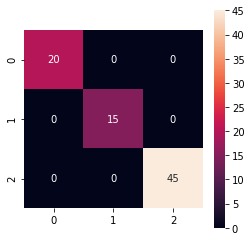

Precision score:  1.0
Recall score:  1.0
F1 score:  1.0


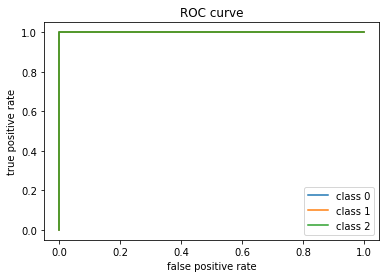

Test score:  1.0
Train score:  1.0


In [22]:
clf = ExtraTreesClassifier(max_depth=10, max_features=1, min_samples_split=2)
analyze_trees_model(clf, X1_test, y1_test, X1_train, y1_train, num_classes=num_of_classes)

## logical_xor

In [23]:
results_xor = grid_search_extratrees(X2_train, y2_train, X2_test, y2_test, max_depths, max_features, min_samples_splits)
results_xor_tr = results_xor.transpose()
results_xor_tr.sort_values(by='f1', ascending=False)

,max_depth,max_features,min_samples_split,f1,precision,recall
6,10.0,2.0,2.0,0.983333,0.983333,0.983333
7,10.0,2.0,10.0,0.983333,0.983333,0.983333
5,10.0,1.0,10.0,0.950000,0.950000,0.950000
9,20.0,1.0,10.0,0.950000,0.950000,0.950000
10,20.0,2.0,2.0,0.950000,0.950000,0.950000
11,20.0,2.0,10.0,0.950000,0.950000,0.950000
4,10.0,1.0,2.0,0.933333,0.933333,0.933333
8,20.0,1.0,2.0,0.916667,0.916667,0.916667
2,2.0,2.0,2.0,0.550000,0.550000,0.550000
3,2.0,2.0,10.0,0.550000,0.550000,0.550000


Для цього датасету простежується така закономірність: при зменшенні max_depth погіршуються результати. Це можна пояснити тим, що параметр max_depth відповідає за максимальну глибину дерева. Нижче наведено додаткові метрики для найкращих параметрів

Confusion matrix:


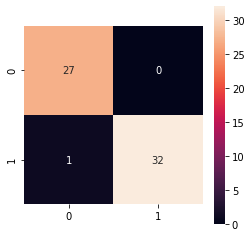

Precision score:  0.9821428571428572
Recall score:  0.9848484848484849
F1 score:  0.9832167832167833


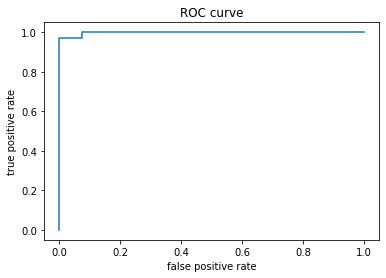

Test score:  0.9833333333333333
Train score:  1.0


In [24]:
clf = ExtraTreesClassifier(max_depth=10, max_features=2, min_samples_split=10)
analyze_trees_model(clf, X2_test, y2_test, X2_train, y2_train, num_classes=0)

# Побудувати ансамблi AdaBoost, Bagging, Stacking, Voting на основi найпростiших моделей

Тепер працюватимемо із створеними власноруч ансамблями моделей. Так як метод додаткових дерев є методом типу Bagging, я використаю саме його.

In [25]:
from sklearn.ensemble import BaggingClassifier

In [105]:
def plot_dec(X, y, clf):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(12,12))
    plt.subplot(2, 2, 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


def analyze_one_model(model, x_test, y_test, x_train, y_train, num_classes):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=0, square=True) 
    plt.show()
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')
    f1 = f1_score(y_test, y_predict, average='macro')
    print("Precision score: ", precision)
    print("Recall score: ", recall)
    print("F1 score: ", f1)
    print("Decision boundaries:")
    plot_dec(x_test, y_test, model)
    print("Test score: ", model.score(x_test, y_test))
    print("Train score: ", model.score(x_train, y_train))
    return f1, precision, recall

    
def analyze_bagging_models(models, x_test, y_test, x_train, y_train, label, num_classes=0):
    result = {'f1' : [], 'f1_bagging' : [], 
              'precision' : [], 'precision_bagging' : [], 
              'recall' : [], 'recall_bagging' : []}
    print(label)
    f1_logregr, precision_logregr, recall_logregr = analyze_one_model(models[0], x_test, y_test, x_train, 
                                                                      y_train, num_classes=num_classes)
    print("\nBagging")
    f1_bagging, precision_bagging, recall_bagging = analyze_one_model(models[1], x_test, y_test, x_train, 
                                                                      y_train, num_classes=num_classes)
    result['f1'].append(f1_logregr)
    result['precision'].append(precision_logregr)
    result['recall'].append(recall_logregr)
    result['f1_bagging'].append(f1_bagging)
    result['precision_bagging'].append(precision_bagging)
    result['recall_bagging'].append(recall_bagging)
    result_df = pd.DataFrame.from_dict(result, orient='index') 
    return result_df

## LogisticRegression vs Bagging

In [106]:
bagging_blobs = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=20)
bagging_xor = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=200)

In [107]:
models_blobs = [logregr_blobs, bagging_blobs]
models_xor = [logregr_xor, bagging_xor]

### make_blobs

Logistic Regression
Confusion matrix:


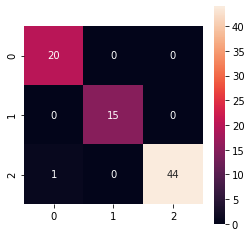

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127
Decision boundaries:


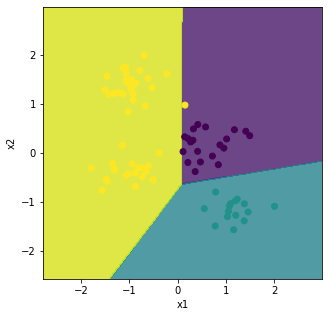

Test score:  0.9875
Train score:  0.984375

Bagging
Confusion matrix:


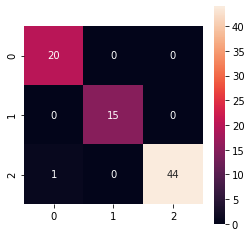

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127
Decision boundaries:


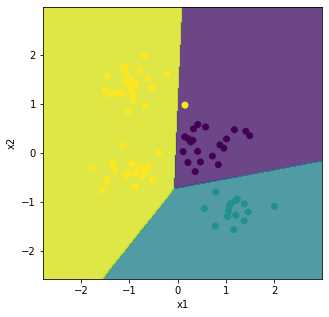

Test score:  0.9875
Train score:  0.9875


In [108]:
result_blobs = analyze_bagging_models(models_blobs, 
                                      X1_test, y1_test, X1_train, y1_train, num_classes=num_of_classes,
                                     label = 'Logistic Regression')

In [109]:
result_blobs

,0
f1,0.988125
f1_bagging,0.988125
precision,0.984127
precision_bagging,0.984127
recall,0.992593
recall_bagging,0.992593


Як бачимо із метрик, результати для обох моделей ніяк не змінилися.

### logical_xor

Logistic Regression
Confusion matrix:


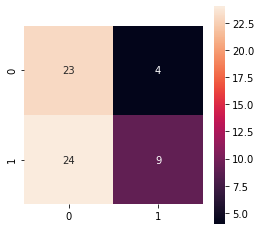

Precision score:  0.5908346972176759
Recall score:  0.5622895622895623
F1 score:  0.5064629847238543
Decision boundaries:


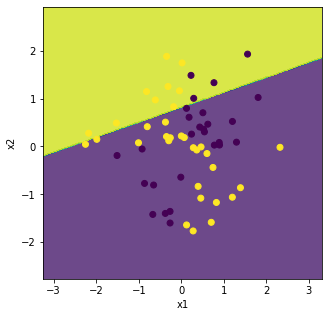

Test score:  0.5333333333333333
Train score:  0.65

Bagging
Confusion matrix:


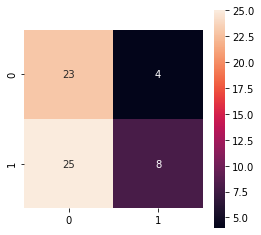

Precision score:  0.5729166666666666
Recall score:  0.5471380471380471
F1 score:  0.48444444444444446
Decision boundaries:


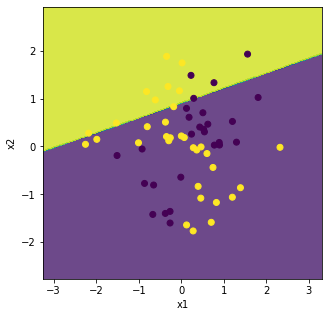

Test score:  0.5166666666666667
Train score:  0.6541666666666667


In [110]:
result_xor = analyze_bagging_models(models_xor, 
                                      X2_test, y2_test, X2_train, y2_train, num_classes=0,
                                    label = 'Logistic Regression')

In [111]:
result_xor

,0
f1,0.506463
f1_bagging,0.484444
precision,0.590835
precision_bagging,0.572917
recall,0.562290
recall_bagging,0.547138


В цьому випадку при при використанні бегінгу результати тільки погіршились.

## MLPClassifier vs Bagging

In [112]:
bagging_blobs = BaggingClassifier(base_estimator=ExtraTreesClassifier(), n_estimators=20)
bagging_xor = BaggingClassifier(base_estimator=ExtraTreesClassifier(), n_estimators=200)
models2_blobs = [trees_blobs, bagging_blobs]
models2_xor = [trees_xor, bagging_xor]

### make_blobs

MLPClassifier
Confusion matrix:


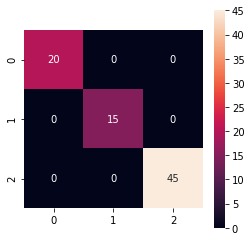

Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
Decision boundaries:


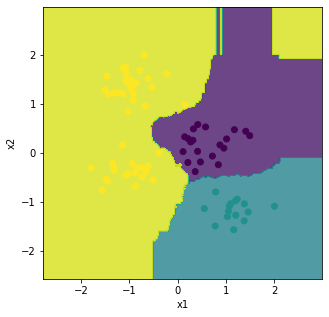

Test score:  1.0
Train score:  1.0

Bagging
Confusion matrix:


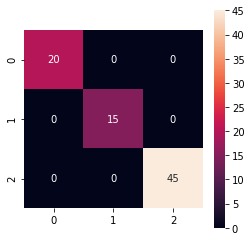

Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
Decision boundaries:


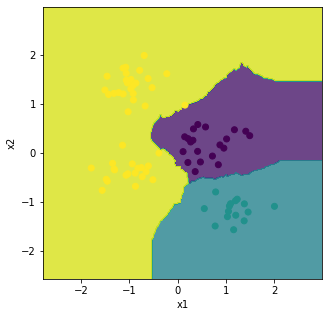

Test score:  1.0
Train score:  1.0


In [113]:
result_blobs = analyze_bagging_models(models2_blobs, 
                                      X1_test, y1_test, X1_train, y1_train, num_classes=0,
                                    label = 'MLPClassifier')

In [114]:
result_blobs

,0
f1,1.0
f1_bagging,1.0
precision,1.0
precision_bagging,1.0
recall,1.0
recall_bagging,1.0


Використання бегінгу ніяк не погіршило і не покращило результати. Але це нормально, що покращення результатів не відбулось, бо вони і так були ідеальними.

### logical_xor

MLPClassifier
Confusion matrix:


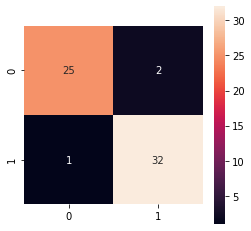

Precision score:  0.9513574660633484
Recall score:  0.9478114478114479
F1 score:  0.9493100535060547
Decision boundaries:


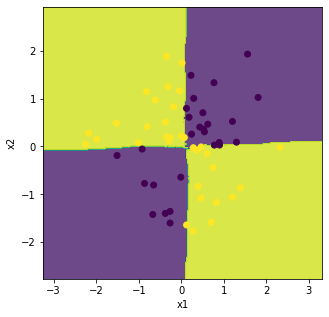

Test score:  0.95
Train score:  1.0

Bagging
Confusion matrix:


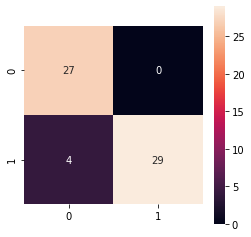

Precision score:  0.935483870967742
Recall score:  0.9393939393939394
F1 score:  0.9332591768631813
Decision boundaries:


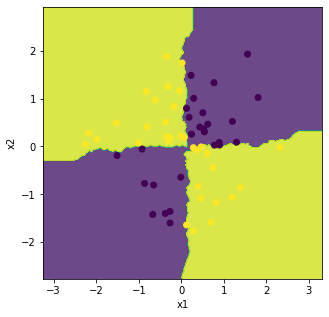

Test score:  0.9333333333333333
Train score:  1.0


In [115]:
result_xor = analyze_bagging_models(models2_xor, 
                                      X2_test, y2_test, X2_train, y2_train, num_classes=0,
                                    label = 'MLPClassifier')

In [116]:
result_xor

,0
f1,0.949310
f1_bagging,0.933259
precision,0.951357
precision_bagging,0.935484
recall,0.947811
recall_bagging,0.939394


А тут бегінг тільки зіпсував результати. Але можна досягти трохи кращих результатів за рахунок зменшення значення n_estimators (див. наступний пункт).

# Побудувати графiки залежностi значень мiри F1_score вiд значення n_estimators

In [126]:
def plot_f1_estimators(model, x_test, y_test, x_train, y_train, estimators_max):
    val = np.zeros(estimators_max)
    x = np.zeros(estimators_max)
    for i in range(1, estimators_max + 1):
        ensModel = BaggingClassifier(base_estimator=model, n_estimators=i).fit(x_train, y_train)
        y_pred = ensModel.predict(x_test)
        val[i - 1] = f1_score(y_test, y_pred, average='macro')
        x[i - 1] = i
    plt.plot(x, val, label='ensemble')
    plt.xlabel('n_estimators')
    plt.ylabel('F1')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y = np.zeros(estimators_max)
    for i in range(estimators_max):
        y[i] = f1_score(y_test, y_pred)
    plt.plot(x, y, linestyle='--', label='model')
    plt.show()

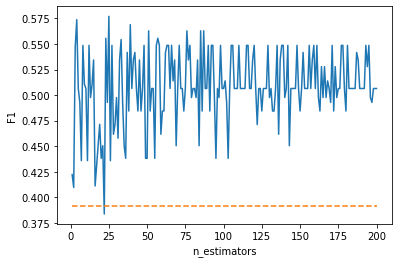

In [127]:
plot_f1_estimators(LogisticRegression(), X2_test, y2_test, X2_train, y2_train, 200)

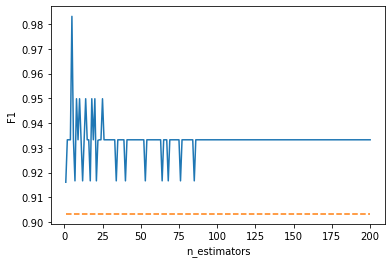

In [128]:
plot_f1_estimators(ExtraTreesClassifier(), X2_test, y2_test, X2_train, y2_train, 200)

Що для першої, що для другої моделі найкраща міра f1 досягається при n_estimators<25, що можна чітко побачити на графіках.

# Побудувати ансамблi на основi найкращих моделей

In [130]:
blobs_bestparams = {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
xor_bestparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
logregr_blobs = LogisticRegression(**blobs_bestparams)
logregr_xor = LogisticRegression(**xor_bestparams)
trees_blobs = ExtraTreesClassifier(max_depth=10, max_features=1, min_samples_split=2)
trees_xor = ExtraTreesClassifier(max_depth=10, max_features=2, min_samples_split=10)

In [131]:
model1_blobs = BaggingClassifier(base_estimator=logregr_blobs, n_estimators=20)
model2_blobs = BaggingClassifier(base_estimator=trees_blobs, n_estimators=20)
model1_xor = BaggingClassifier(base_estimator=logregr_xor, n_estimators=5)
model2_xor = BaggingClassifier(base_estimator=trees_xor, n_estimators=5)

## make_blobs

base_estimator=LogisticRegression
Confusion matrix:


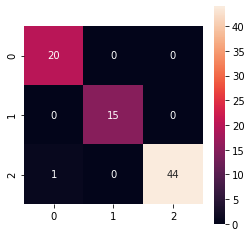

Precision score:  0.9841269841269842
Recall score:  0.9925925925925926
F1 score:  0.988124600347127
Decision boundaries:


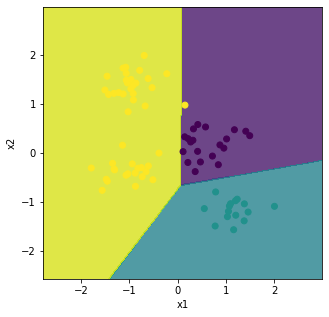

Test score:  0.9875
Train score:  0.984375


base_estimator=ExtraTreesClassifier
Confusion matrix:


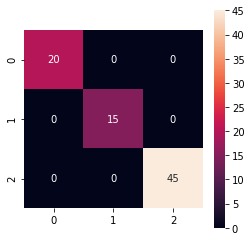

Precision score:  1.0
Recall score:  1.0
F1 score:  1.0
Decision boundaries:


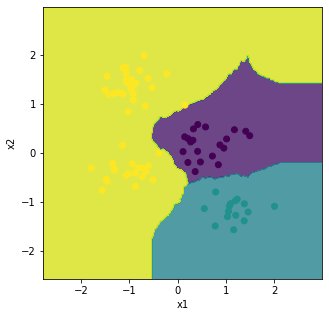

Test score:  1.0
Train score:  1.0


(1.0, 1.0, 1.0)

In [134]:
print('base_estimator=LogisticRegression')
analyze_one_model(model1_blobs, X1_test, y1_test, X1_train, y1_train, num_classes=0)
print('\n\nbase_estimator=ExtraTreesClassifier')
analyze_one_model(model2_blobs, X1_test, y1_test, X1_train, y1_train, num_classes=0)

## logical_xor

base_estimator=LogisticRegression
Confusion matrix:


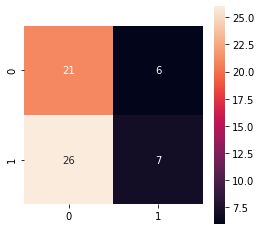

Precision score:  0.49263502454991814
Recall score:  0.494949494949495
F1 score:  0.43595769682726204
Decision boundaries:


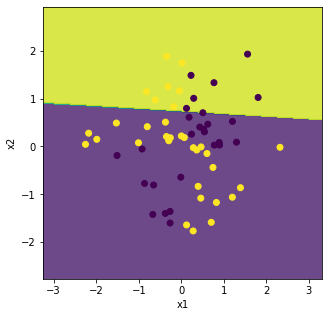

Test score:  0.4666666666666667
Train score:  0.5583333333333333


base_estimator=ExtraTreesClassifier
Confusion matrix:


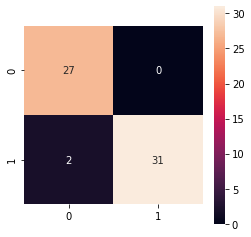

Precision score:  0.9655172413793103
Recall score:  0.9696969696969697
F1 score:  0.9665178571428572
Decision boundaries:


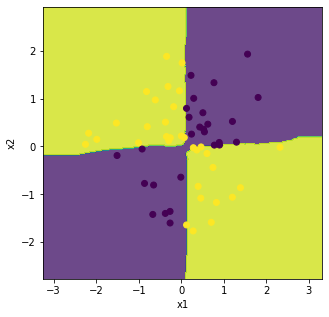

Test score:  0.9666666666666667
Train score:  1.0


(0.9665178571428572, 0.9655172413793103, 0.9696969696969697)

In [135]:
print('base_estimator=LogisticRegression')
analyze_one_model(model1_xor, X2_test, y2_test, X2_train, y2_train, num_classes=0)
print('\n\nbase_estimator=ExtraTreesClassifier')
analyze_one_model(model2_xor, X2_test, y2_test, X2_train, y2_train, num_classes=0)

Як можна побачити, загалом, використання ExtraTreesClassifier() в якості base_estimator дає кращі результати, ніж LogisticRegression(), особливо це помітно на другому датасеті.

# Висновки

В роботі було я реалізувала моделі нейронних мереж, ансамблі з використанням дерев (метод додаткових дерев), а також власноруч створений ансамбль типу bagging із використанням моделі логістичної регресії та нейронних мереж. На основі отриманих результатів я зробила висновок, що використання ансамблів в багатьох випадках покращує результати класифікації при правильному підборі параметрів основної моделі ансамблю та кількості цих моделей. Також слід зазначити, що власне моделі нейронних мереж також є доволі ефективними: при грамотному підборі параметрів було майже ідеально класифіковано другий набір даних (з яким були проблеми у другій лабі). Були побудовані моделі ансамблів із використанням найкращих показників основних моделей.